In [2]:
from models.vqgan import IBQSharedModel
from datasets import load_dataset

tokenizer = IBQSharedModel(ckpt_path="./imagenet_64/vqgan_ibq/latest.ckpt", n_embed=16384, embed_dim=256)

dataset = load_dataset("benjamin-paine/imagenet-1k-64x64", trust_remote_code=True, cache_dir="./.cache")["train"]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/sprucecampbell/Documents/ai/ndp/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling 

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


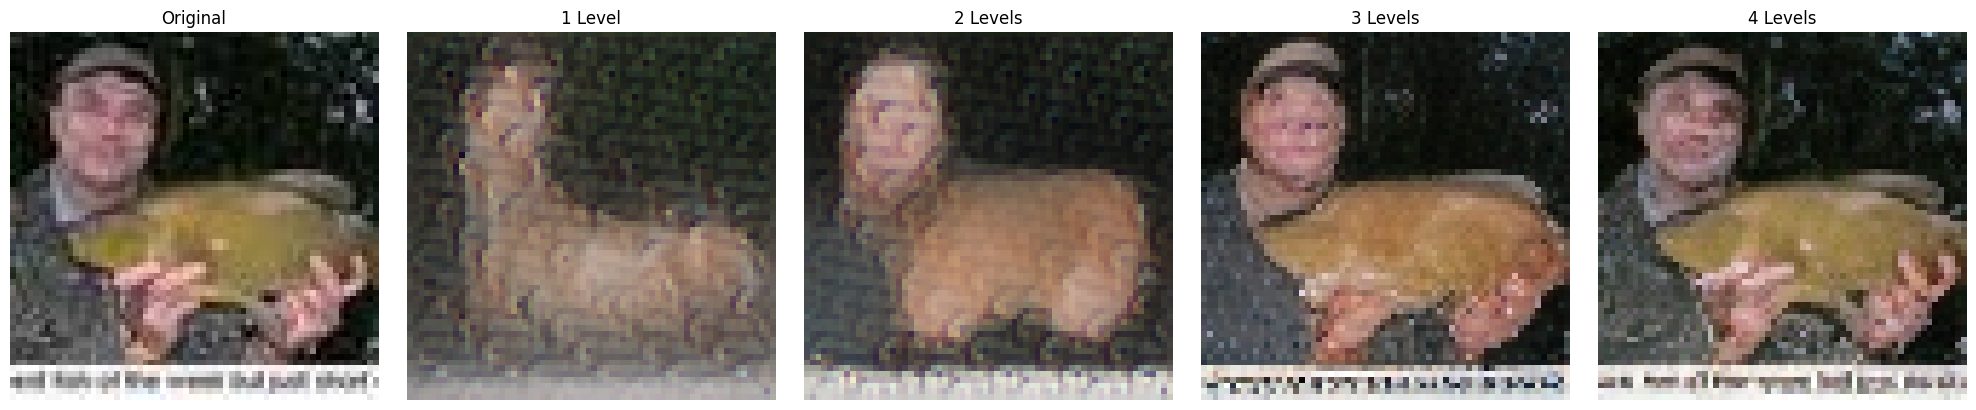

In [22]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

img = dataset[40]["image"]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

img = transform(img).unsqueeze(0)  # Add batch dimension
print(img.shape)

_, _, _, _, _, ((_, _, ind1), (_, _, ind2), (_, _, ind3), (_, _, ind4)) = tokenizer.encode(img)

q1 = tokenizer.quantize.get_codebook_entry(ind1, shape=(1, 16, 16, 256))
q2 = tokenizer.quantize.get_codebook_entry(ind2, shape=(1, 8, 8, 256))
q3 = tokenizer.quantize.get_codebook_entry(ind3, shape=(1, 4, 4, 256))
q4 = tokenizer.quantize.get_codebook_entry(ind4, shape=(1, 2, 2, 256))

z1, z2, z3, z4 = tokenizer.get_zero_tokens(q1, q2, q3, q4, q1.device)
def show_images(tensors, titles=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, tensor in enumerate(tensors):
        x = tensor.squeeze(0)  # Remove batch dimension
        x = x.permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
        x = ((x + 1.0) * 127.5).clamp(0, 255).to(torch.uint8)  # Denormalize and convert to uint8
        x = x.cpu().numpy()
        
        axes[i].imshow(x)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    
    plt.tight_layout()
    plt.show()

# Generate all images
x_orig = img
x_1 = tokenizer.decode(z1, z2, z3, q4)
x_2 = tokenizer.decode(z1, z2, q3, q4)
x_3 = tokenizer.decode(z1, q2, q3, q4)
x_4 = tokenizer.decode(q1, q2, q3, q4)

# Show all images in a grid
titles = ['Original', '1 Level', '2 Levels', '3 Levels', '4 Levels']
show_images([x_orig, x_1, x_2, x_3, x_4], titles)
